<a href="https://colab.research.google.com/github/mingyung-park/Honors-Thesis/blob/pre-experiment-checks/experiments/pre-checks/test_LE_calculation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

2024-10-17,24

# Test FOL Logical Equivalence Metric

# Load Dataset

In [ ]:
!pip install datasets
!pip install huggingface_hub
!pip install svgling #for visualizing parse tree

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 kB 3.6 MB/s eta 0:00:00


In [ ]:
from huggingface_hub import login
from datasets import load_dataset
dataset = load_dataset("yuan-yang/MALLS-v0")
dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/2.27k [00:00<?, ?B/s]

MALLS-v0.1-train.json:   0%|          | 0.00/6.36M [00:00<?, ?B/s]

MALLS-v0.1-test.json:   0%|          | 0.00/231k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/27284 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['FOL', 'NL'],
        num_rows: 27284
    })
    test: Dataset({
        features: ['FOL', 'NL'],
        num_rows: 1000
    })
})

In [ ]:
test_dataset = dataset['test']
test_dataset[0]

{'FOL': '∀x (Vacation(x) ∧ Relaxing(x) → (BeautifulScenery(x) ∧ EnjoyableActivities(x)))',
 'NL': 'A vacation is relaxing if it includes beautiful scenery and enjoyable activities.'}

# FOL Logical Equivalence

Code From https://github.com/gblackout/LogicLLaMA/tree/main

## Test Basic Code


In [ ]:
import itertools
import numpy as np
from parser import parse_fol_expression

In [ ]:
import signal
from typing import Callable
import os
from os.path import join as joinpath


def all_exists(*args):
    return all(e is not None for e in args)


def any_exists(*args):
    return any(e is not None for e in args)


class FuncTimeOutError(Exception):
    pass


def timeout_handler(signum, frame):
    raise FuncTimeOutError("Function timed out")


def has_same_obj_in_list(obj, ls):
    return any(obj is e for e in ls)


def wrap_function_with_timeout(func: Callable, timeout: int):
    def wrapped_function(*args, **kwargs):
        signal.signal(signal.SIGALRM, timeout_handler)
        signal.alarm(timeout)
        try:
            result = func(*args, **kwargs)
            signal.alarm(0)  # Reset the alarm
        except FuncTimeOutError:
            return None
        return result

    return wrapped_function

def make_parent_dirs(fp:str):
    parts = fp.split('/')
    if len(parts) == 1:
        return

    parent_dir = joinpath(*parts[:-1])
    if not os.path.isdir(parent_dir):
        os.makedirs(parent_dir)

In [ ]:
import json
from os.path import join as joinpath
import os
import re
import nltk
from copy import deepcopy
import numpy as np
from nltk.tree import Tree
from itertools import product, combinations, permutations
from typing import Optional, Union, List, Dict, Callable
import random
# from Levenshtein import distance as edit_dist


# TODO inefficient
op_ls = ['⊕', '∨', '∧', '→', '↔', '∀', '∃', '¬', '(', ')', ',']

sym_reg = re.compile(r'[^⊕∨∧→↔∀∃¬(),]+')

cfg_template = """
S -> F | Q F
Q -> QUANT VAR | QUANT VAR Q
F -> '¬' '(' F ')' | '(' F ')' | F OP F | L
OP -> '⊕' | '∨' | '∧' | '→' | '↔'
L -> '¬' PRED '(' TERMS ')' | PRED '(' TERMS ')'
TERMS -> TERM | TERM ',' TERMS
TERM -> CONST | VAR
QUANT -> '∀' | '∃'
"""

# used in perturbation
last_nt_nodes = set(['PRED', 'OP', 'CONST', 'VAR', 'QUANT'])
# used in node insertion
insertable_nt_nodes = set(['Q', 'S', 'TERMS', 'F'])
# used in node deletion
deleteable_nt_nodes = set(['Q', 'TERMS', 'F', 'L'])

def parse_text_FOL_to_tree(rule_str):
    """
        Parse a text FOL rule into nltk.tree

        Returns: nltk.tree, or None if the parse fails
    """
    rule_str = reorder_quantifiers(rule_str)

    r, parsed_fol_str = msplit(rule_str)
    cfg_str = make_cfg_str(r)

    grammar = nltk.CFG.fromstring(cfg_str)
    parser = nltk.ChartParser(grammar)
    tree = parser.parse_one(r)

    return tree


def reorder_quantifiers(rule_str):
    matches = re.findall(r'[∃∀]\w', rule_str)
    for match in matches[::-1]:
        rule_str = '%s ' % match + rule_str.replace(match, '', 1)
    return rule_str


def msplit(s):
    for op in op_ls:
        s = s.replace(op, ' %s ' % op)
    r = [e.strip() for e in s.split()]
    #remove ' from the string if it contains any: this causes error in nltk cfg parsing
    r = [e.replace('\'', '') for e in r]
    r = [e for e in r if e != '']

    # deal with symbols with spaces like "dc universe" and turn it to "DcUniverse"
    res = []
    cur_str_ls = []
    for e in r:
        if (len(e) > 1) and sym_reg.match(e):
            cur_str_ls.append(e[0].upper() + e[1:])
        else:
            if len(cur_str_ls) > 0:
                res.extend([''.join(cur_str_ls), e])
            else:
                res.extend([e])
            cur_str_ls = []
    if len(cur_str_ls) > 0:
        res.append(''.join(cur_str_ls))

    # re-generate the FOL string
    make_str_ls = []
    for ind, e in enumerate(r):
        if re.match(r'[⊕∨∧→↔]', e):
            make_str_ls.append(' %s ' % e)
        elif re.match(r',', e):
            make_str_ls.append('%s ' % e)
        # a logical variable
        elif (len(e) == 1) and re.match(r'\w', e):
            if ((ind - 1) >= 0) and ((r[ind-1] == '∃') or (r[ind-1] == '∀')):
                make_str_ls.append('%s ' % e)
            else:
                make_str_ls.append(e)
        else:
            make_str_ls.append(e)

    return res, ''.join(make_str_ls)


def make_cfg_str(token_ls):
    """
    NOTE: since nltk does not support reg strs like \w+, we cannot separately recognize VAR, PRED, and CONST.
    Instead, we first allow VAR, PRED, and CONST to be matched with all symbols found in the FOL; once the tree is
    parsered, we then go back and figure out the exact type of each symbols
    """
    sym_ls = list(set([e for e in token_ls if sym_reg.match(e)]))
    sym_str = ' | '.join(["'%s'" % s for s in sym_ls])
    cfg_str = cfg_template + 'VAR -> %s\nPRED -> %s\nCONST -> %s' % (sym_str,sym_str,sym_str)
    return cfg_str


def symbol_resolution(tree):
    lvars, consts, preds = set(), set(), set()

    if tree[0].label() == 'Q':
        isFOL = True
        main_tree = tree[1]
        for sym, tag in tree[0].pos():
            if tag == 'VAR':
                lvars.add(sym)
    else:
        isFOL = False
        main_tree = tree[0]

    preorder_resolution(main_tree, lvars, consts, preds)

    return isFOL, lvars, consts, preds


def preorder_resolution(tree, lvars, consts, preds):
    # reached terminal nodes
    if isinstance(tree, str):
        return

    if tree.label() == 'PRED':
        preds.add(tree[0])
        return

    if tree.label() == 'TERM':
        sym = tree[0][0]
        if sym in lvars:
            tree[0].set_label('VAR')
        else:
            tree[0].set_label('CONST')
            consts.add(sym)
        return

    for child in tree:
        preorder_resolution(child, lvars, consts, preds)


class Rule:
    def __init__(self, isFOL, lvars, consts, preds, tree):
        self.isFOL = isFOL
        self.lvars = lvars
        self.consts = consts
        self.preds = preds
        self.tree = tree

    def rule_str(self):
        # TODO inefficient
        _, rule_str = msplit(''.join(self.tree.leaves()))
        return rule_str

    def _get_nodes(
            self,
            root,
            nodes,
            allowed_labels=None,
            not_allowed_nodes=None,
            not_allowed_nodes_in_subtree=False
    ):
        all_child_allowed = True

        if isinstance(root, str):
            return all_child_allowed

        # post-order check children
        for child in root:
            child_allowed = self._get_nodes(
                child,
                nodes,
                allowed_labels,
                not_allowed_nodes,
                not_allowed_nodes_in_subtree
            )
            all_child_allowed = all_child_allowed and child_allowed
        # this is twisted... what i mean is that if you don't want to filter the subtrees then simply set
        # all_child_allowed to true regardless of the post-order check result
        if not not_allowed_nodes_in_subtree:
            all_child_allowed = True

        root_is_allowed = (not_allowed_nodes is None) or all(e is not root for e in not_allowed_nodes)
        tree_is_allowed = all_child_allowed and root_is_allowed

        if (
                ((allowed_labels is None) or (root.label() in allowed_labels))
                and tree_is_allowed
        ):
            nodes.append(root)

        return tree_is_allowed

    def get_nodes(
            self,
            root,
            allowed_labels=None,
            not_allowed_nodes=None,
            not_allowed_nodes_in_subtree=False
    ):
        """
            get tree nodes from a tree

            Args:
                root:
                allowed_labels: None or a set of strs; only nodes with the allowed label is included
                not_allowed_nodes: None or a list of node objects; only node objects that are not in the list
                is included
                not_allowed_nodes_in_subtree: set to True to also filter out nodes whose subtree nodes are in
                not_allowed_nodes, this is used when finding the deletable nodes (we want to find nodes whose entire
                subtree is not perturbed before)
        """
        if not_allowed_nodes_in_subtree:
            assert all_exists(not_allowed_nodes), 'must specify not_allowed_nodes'

        nodes = []
        self._get_nodes(
            root,
            nodes,
            allowed_labels,
            not_allowed_nodes,
            not_allowed_nodes_in_subtree
        )
        return nodes

    def random_node_by_label(
            self,
            root,
            allowed_labels=None,
            not_allowed_nodes=None,
            not_allowed_nodes_in_subtree=False
    ):
        nodes = self.get_nodes(root, allowed_labels, not_allowed_nodes, not_allowed_nodes_in_subtree)
        choice = nodes[int(np.random.randint(len(nodes)))] if len(nodes) > 0 else None
        return choice

    def get_all_fopf(self, root, res):
        if isinstance(root, str):
            return

        if root.label() == 'F':
            if len(root) == 3 and all(not isinstance(child, str) for child in root):
                # this is a F - F OP F subtree
                res.append(root)

        for child in root:
            self.get_all_fopf(child, res)

    def order_of(self, node):
        cnt, flag = self._inorder_order(self.tree, node, 0)
        assert flag
        return cnt

    def parent_of(self, root, node):
        if isinstance(root, str):
            return None

        for child in root:
            if child is node:
                return root
            parent = self.parent_of(child, node)
            if all_exists(parent):
                return parent

        return None

    def _inorder_order(self, root, node, order_cnt):
        if root is node:
            return order_cnt + 1, True

        if isinstance(root, str):
            return order_cnt + (root == node[0]), False

        cnt = order_cnt
        flag = False
        for n in root:
            cnt, flag = self._inorder_order(n, node, cnt)
            if flag:
                break

        return cnt, flag


class Sample:
    def __init__(self, nl, rule: Rule):
        self.nl = nl
        self.rule = rule
        self.perturbed_rule = None

        word_reg = re.compile(r'^\w+$')
        nl_words = [e.strip().lower() for e in self.nl.split()]
        nl_words = [e for e in nl_words if word_reg.match(e) is not None]

        self.symbols = list(self.rule.lvars) + list(self.rule.consts) + list(self.rule.preds) + nl_words
        assert len(self.symbols) > 1, 'to avoid dead loop; maybe improve later'

    @classmethod
    def get_changeable_nodes(cls, rule: Rule, occupied_nodes):
        return rule.get_nodes(
            rule.tree,
            allowed_labels=last_nt_nodes,
            not_allowed_nodes=occupied_nodes,
            not_allowed_nodes_in_subtree=False
        )

    @classmethod
    def get_insertable_nodes(cls, rule: Rule):
        return rule.get_nodes(
            rule.tree,
            allowed_labels=insertable_nt_nodes,
            not_allowed_nodes=None,
            not_allowed_nodes_in_subtree=False
        )

    @classmethod
    def get_deletable_nodes(cls, rule: Rule, occupied_nodes):

        # first, we find nodes that can be deleted entirely, this means its subtree cannot be occupied
        nodes = rule.get_nodes(
            rule.tree,
            allowed_labels=deleteable_nt_nodes,
            not_allowed_nodes=occupied_nodes,
            not_allowed_nodes_in_subtree=False
        )

        deletable_nodes = []
        for node in nodes:
            label = node.label()

            if label == 'Q':
                # a Q node whose direct QUANT and VAR children are not occupied is deletable
                if has_same_obj_in_list(node[0], occupied_nodes) or has_same_obj_in_list(node[1], occupied_nodes):
                    continue

            elif label == 'TERMS':
                # only TERMS node with a TERMS parent is deletable
                parent = rule.parent_of(rule.tree, node)
                if parent.label() != 'TERMS':
                    continue
                # only TERMS node with unoccupied direct TERM and VAR child is deletable
                if has_same_obj_in_list(node[0], occupied_nodes) or has_same_obj_in_list(node[0][0], occupied_nodes):
                    continue

            elif label == 'F':
                # only F node with siblings of F OP F is deletable
                parent = rule.parent_of(rule.tree, node)
                if len(parent) != 3:
                    continue
                if isinstance(parent[0], str):
                    continue
                if isinstance(parent[2], str):
                    continue
                if not (
                        parent[0].label() == 'F'
                        and parent[1].label() == 'OP'
                        and parent[2].label() == 'F'
                ):
                    continue
                # only F node with an entire unoccupied tree is deletable
                # I check this by checking if this F node is in the unoccupied_nodes while
                # not_allowed_nodes_in_subtree=True
                unoccupied_nodes = rule.get_nodes(
                    node,
                    allowed_labels=deleteable_nt_nodes,
                    not_allowed_nodes=occupied_nodes,
                    not_allowed_nodes_in_subtree=True
                )
                if not has_same_obj_in_list(node, unoccupied_nodes):
                    continue

            else:
                continue

            deletable_nodes.append(node)

        # secondly, we find nodes that has deletable negation, where it's fine if the subtree is occupied
        nodes_with_deletable_negation = []
        for node in nodes:
            label = node.label()
            # only F/L node has a deletable negation if it has negation in it
            if (label == 'F') or (label == 'L'):
                if isinstance(node[0], str) and (node[0] == '¬'):
                    nodes_with_deletable_negation.append(node)

        # combine the possible deletions and assign a mode tag
        deletable_nodes = \
            [(e, 'delete_node') for e in deletable_nodes] \
            + [(e, 'delete_negation') for e in nodes_with_deletable_negation]

        return deletable_nodes



class VecRuleEvaluator:

    dummy_input_str: str = '#DUMMY'
    dummy_distance: int = 10000

    # 기본 인풋의 레벤슈타인 거리
    @classmethod
    def default_input_similarity(cls, e1: str, e2: str):
        """ 기능: 두 리터럴(e1, e2)의 유사도를 계산합니다. nltk.edit_distance 함수를 사용해 두 문자열 간의 Levenshtein 거리(편집 거리)를 구합니다.
        특이 사항: dummy_input_str로 시작하는 입력은 비교를 피하고, 유사도 거리로 큰 값을 반환합니다(dummy_distance)."""
        if e1.startswith(cls.dummy_input_str) or e2.startswith(cls.dummy_input_str): # 더미 인풋에 대해서는 매우 큰 값으로
            return cls.dummy_distance
        return edit_dist(e1, e2)

    #레벤슈타인 거리를 통해서 가장 거리가 가까운 리터럴들 끼리 매칭함.
    @classmethod
    def enumerate_bindings_with_greedy_match(cls, ls1: List[str], ls2: List[str], top_n: int): # 두 list ls1, ls2 에서 리터럴 매칭
        """
            Given two lists of strings ls1 and ls2, yields the ind bindings of ls2 strings that matches the strings in
            ls1. I use greedy match and yields starts from the best to the worst binding until full enumeration or hit
            the top_n bound
            각 리터럴 ls1의 항목과 ls2의 항목 간의 유사도를 계산하고, 그중 가장 작은 거리(즉, 가장 유사한 리터럴)를 찾아 매칭합니다.
이미 사용된 리터럴은 매칭에서 제외합니다.
최대 top_n개 매칭까지만 수행합니다.
        """

        used_inds = []

        def _enum_bindings(ind1: int):
            if ind1 == len(ls1):
                yield deepcopy(used_inds)
                return
            e1 = ls1[ind1]
            match_ls = [
                (ind, cls.default_input_similarity(e1, e2))
                for ind, e2 in enumerate(ls2) if ind not in used_inds
            ]
            match_ls.sort(key=lambda x:x[1])
            for ind, dist in match_ls:
                used_inds.append(ind)
                for inds in _enum_bindings(ind1+1):
                    yield inds
                used_inds.pop()

        for cnt, ind_ls in enumerate(_enum_bindings(0)):
            yield ind_ls
            if cnt + 1 == top_n:
                break

    #FOL트리에서 리터럴 추출
    @classmethod
    def find_inputs(cls, root, input_set=None):
        """FOL 트리 구조에서 L이라는 레이블을 가진 노드를 탐색하여 그 리터럴을 추출합니다.
        리터럴의 부정 연산자(¬)가 있을 경우 이를 처리하여 올바르게 저장합니다."""
        if isinstance(root, str):
            return

        label = root.label()

        if label == 'L':
            literal_str = ''.join(root.leaves())
            literal_str = literal_str[1:] if literal_str[0] == '¬' else literal_str
            if input_set is None:
                input_set = set()
            input_set.add(literal_str)
        else:
            for child in root:
                cls.find_inputs(child, input_set)

    @classmethod # 리터럴 수에 따라 가능한 진리값 조합을 생성
    def gen_input_vecs(cls, num_inputs):
        """itertools.product를 사용하여 [True, False]의 가능한 조합을 만들고, 이를 np.array로 변환합니다."""
        return np.array(list(product([False, True], repeat=num_inputs)))


    @classmethod # 주어진 리터럴에 대한 진리값을 바탕으로 논리 연산 수행
    def from_nltk_tree(cls, root, name2ind_dict, input_vecs):
        """
        트리의 루트부터 시작하여, 각 논리 연산자(⊕, ∨, ∧, →, ↔)에 맞는 연산을 수행합니다.
        리터럴(L)에 도달하면, 해당 리터럴에 대한 진리값을 input_vecs에서 가져와서 반환합니다.
        """
        assert not isinstance(root, str), 'something wrong with the rule or the algo; you should not parse a leave'

        label = root.label()

        if label == 'S':

            return cls.from_nltk_tree(root[-1], name2ind_dict, input_vecs)

        elif label == 'F':

            # the case F -> L
            if (len(root) == 1) and (root[0].label() == 'L'):
                return cls.from_nltk_tree(root[0], name2ind_dict, input_vecs)

            # the case F -> '¬' '(' F ')' | (' F ')'
            elif root[-2].label() == 'F':

                isnegated_rule = isinstance(root[0], str) and (root[0] == '¬')
                res = cls.from_nltk_tree(root[-2], name2ind_dict, input_vecs)

                if isnegated_rule:
                    res = ~res

                return res

            # the case F -> F OP F
            elif root[-2].label() == 'OP':

                p, q = cls.from_nltk_tree(root[0], name2ind_dict, input_vecs), \
                       cls.from_nltk_tree(root[-1], name2ind_dict, input_vecs)

                op = root[1][0]
                if op == '⊕':
                    return np.logical_xor(p, q)
                elif op == '∨':
                    return np.logical_or(p, q)
                elif op == '∧':
                    return np.logical_and(p, q)
                elif op == '→':
                    return np.logical_or(~p, q)
                elif op == '↔':
                    return np.logical_or(np.logical_and(p, q), np.logical_and(~p, ~q))
                else:
                    raise ValueError

        elif label == 'L':

            isnegated_literal = isinstance(root[0], str) and (root[0] == '¬')

            literal_str = ''.join(root.leaves())
            # remove the possible negation at the beginning
            literal_str = literal_str[1:] if isnegated_literal else literal_str

            vec = input_vecs[:, name2ind_dict[literal_str]]

            if isnegated_literal:
                vec = ~vec

            return vec

        else:
            raise ValueError

    @classmethod # 계산
    def find_best_LE_score(
            cls,
            true_root,
            pred_root,
            soft_binding: bool,
            greedy_match: bool,
            top_n: int,
            verbose: bool = False
    ):
        """
            Given the groundtruth and the predicted nltk FOL trees, compute the truth tables over all
            literal bindings and returns the best one
리터럴 추출: find_inputs 메서드를 사용하여, Groundtruth 트리(true_root)와 예측된 트리(pred_root)에서 리터럴(입력)을 각각 추출합니다.
입력 크기 조정: Groundtruth와 Predicted 논리식의 리터럴 개수가 다를 경우, soft_binding 옵션에 따라 더미 리터럴(dummy_input_str)을 추가합니다.
진리표 생성: gen_input_vecs 메서드를 사용하여 가능한 모든 진리값 조합을 생성합니다.
트리 평가: from_nltk_tree 메서드를 사용하여 각 트리의 논리 연산을 수행하고, 결과 벡터(true_res_vec, pred_res_vec)를 계산합니다.
Greedy 매칭: enumerate_bindings_with_greedy_match를 사용하여 가장 유사한 리터럴 매칭을 찾습니다.
LE 점수 계산: Groundtruth 결과 벡터와 Predicted 결과 벡터가 얼마나 일치하는지 계산하여 LE 점수를 산출합니다.
        """

        # first we find "inputs" in each tree, i.e. the set of unique literals in a FOL
        true_inputs, pred_inputs = set(), set()
        VecRuleEvaluator.find_inputs(true_root, true_inputs), VecRuleEvaluator.find_inputs(pred_root, pred_inputs)
        true_inputs, pred_inputs = list(true_inputs), list(pred_inputs)
        n_true_inputs, n_pred_inputs = len(true_inputs), len(pred_inputs)
        min_n, max_n = sorted([n_true_inputs, n_pred_inputs])

        best_score, best_binded_pred_inputs = 0., None

        # once we found the inputs, then we deal with the case where # inputs in two trees are different
        # either we do soft binding by adding dummy inputs to the shorter ones, or we simply return 0
        if n_true_inputs != n_pred_inputs:
            if soft_binding:
                # extend the shorter inputs to the max number of inputs by adding dummy input names
                ls_to_extend = true_inputs if n_true_inputs < max_n else pred_inputs
                ls_to_extend.extend([f'{cls.dummy_input_str}_{ind}' for ind in range(max_n-min_n)])
            else:
                return best_score, true_inputs, best_binded_pred_inputs

        # at this point, we have two list ofs inputs of the same length and we will find the input binding that yields
        # the best score
        input_vecs = VecRuleEvaluator.gen_input_vecs(len(true_inputs))
        true_name2ind_dict = dict((e, ind) for ind,e in enumerate(true_inputs))
        true_res_vec = VecRuleEvaluator.from_nltk_tree(true_root, true_name2ind_dict, input_vecs)

        ind_binding_enumerator = \
            cls.enumerate_bindings_with_greedy_match(true_inputs, pred_inputs, top_n) if greedy_match \
            else permutations(list(range(max_n)))

        for cnt_ind, binded_pred_inputs_inds in enumerate(ind_binding_enumerator):
            binded_pred_inputs = [pred_inputs[ind] for ind in binded_pred_inputs_inds]
            pred_name2ind_dict = dict((e, ind) for ind, e in enumerate(binded_pred_inputs))
            pred_res_vec = VecRuleEvaluator.from_nltk_tree(pred_root, pred_name2ind_dict, input_vecs)
            score = (pred_res_vec == true_res_vec).mean(dtype=np.float32).item()

            if verbose:
                print('{0}\n{1}\n{2}\n---\n'.format(
                    score, true_inputs, binded_pred_inputs)
                )

            if score > best_score:
                best_score = score
                best_binded_pred_inputs = binded_pred_inputs

            if cnt_ind + 1 >= top_n:
                break

        return best_score, true_inputs, best_binded_pred_inputs

In [ ]:
groundtruth_fol = '∀x (P(x) → Q(x))'
predicted_fol = '∀x (Q(x) → P(x))'

# Groundtruth 및 예측 FOL을 NLTK 트리로 변환
groundtruth_tree = parse_text_FOL_to_tree(groundtruth_fol)
predicted_tree = parse_text_FOL_to_tree(predicted_fol)


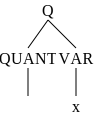

In [ ]:
groundtruth_tree[0]

In [ ]:
# VecRuleEvaluator를 사용해 LE 점수 계산
le_score, true_inputs, binded_pred_inputs = VecRuleEvaluator.find_best_LE_score(
    true_root=groundtruth_tree,  # 참 트리
    pred_root=predicted_tree,    # 예측 트리
    soft_binding=True,           # input 개수가 다를 때 soft binding을 사용할지 여부
    greedy_match=True,           # greedy 매칭 여부
    top_n=5,                     # 최상위 매칭 결과만 반환
    verbose=True                 # 디버깅 출력을 위한 옵션
)

# 결과 출력
print(f"LE Score: {le_score}")
print(f"True Inputs: {true_inputs}")
print(f"Bounded Pred Inputs: {binded_pred_inputs}")


0.5
['P(x)', 'Q(x)']
['P(x)', 'Q(x)']
---

1.0
['P(x)', 'Q(x)']
['Q(x)', 'P(x)']
---

LE Score: 1.0
True Inputs: ['P(x)', 'Q(x)']
Bounded Pred Inputs: ['Q(x)', 'P(x)']


---
## Customizing VecRuleEvaluator Class

In [7]:
%cd /content/drive/MyDrive/독립연구/codes

/content/drive/MyDrive/독립연구/codes


In [3]:
! pip install levenshtein

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 34.1 MB/s eta 0:00:00


In [81]:
import json
from os.path import join as joinpath
import os
import re
import nltk
import pandas as pd
from copy import deepcopy
import numpy as np
from nltk.tree import Tree
from itertools import product, combinations, permutations
from typing import Optional, Union, List, Dict, Callable
import random
from Levenshtein import distance as edit_dist

class VecRuleEvaluator:

    dummy_input_str: str = '#DUMMY'
    dummy_distance: int = 10000

    # 기본 인풋의 레벤슈타인 거리
    @classmethod
    def default_input_similarity(cls, e1: str, e2: str):
        """ 기능: 두 리터럴(e1, e2)의 유사도를 계산합니다. nltk.edit_distance 함수를 사용해 두 문자열 간의 Levenshtein 거리(편집 거리)를 구합니다.
        특이 사항: dummy_input_str로 시작하는 입력은 비교를 피하고, 유사도 거리로 큰 값을 반환합니다(dummy_distance)."""
        if e1.startswith(cls.dummy_input_str) or e2.startswith(cls.dummy_input_str): # 더미 인풋에 대해서는 매우 큰 값으로
            return cls.dummy_distance
        return edit_dist(e1, e2)

    #레벤슈타인 거리를 통해서 가장 거리가 가까운 리터럴들 끼리 매칭함.
    @classmethod
    def enumerate_bindings_with_greedy_match(cls, ls1: List[str], ls2: List[str], top_n: int): # 두 list ls1, ls2 에서 리터럴 매칭
        """
            Given two lists of strings ls1 and ls2, yields the ind bindings of ls2 strings that matches the strings in
            ls1. I use greedy match and yields starts from the best to the worst binding until full enumeration or hit
            the top_n bound
            각 리터럴 ls1의 항목과 ls2의 항목 간의 유사도를 계산하고, 그중 가장 작은 거리(즉, 가장 유사한 리터럴)를 찾아 매칭합니다.
이미 사용된 리터럴은 매칭에서 제외합니다.
최대 top_n개 매칭까지만 수행합니다.
        """

        used_inds = []

        def _enum_bindings(ind1: int):
            if ind1 == len(ls1):
                yield deepcopy(used_inds)
                return
            e1 = ls1[ind1]
            match_ls = [
                (ind, cls.default_input_similarity(e1, e2))
                for ind, e2 in enumerate(ls2) if ind not in used_inds
            ]
            match_ls.sort(key=lambda x:x[1])
            for ind, dist in match_ls:
                used_inds.append(ind)
                for inds in _enum_bindings(ind1+1):
                    yield inds
                used_inds.pop()

        for cnt, ind_ls in enumerate(_enum_bindings(0)):
            yield ind_ls
            if cnt + 1 == top_n:
                break

    #FOL트리에서 리터럴 추출
    @classmethod
    def find_inputs(cls, root, input_set=None):
        """FOL 트리 구조에서 L이라는 레이블을 가진 노드를 탐색하여 그 리터럴을 추출합니다.
        리터럴의 부정 연산자(¬)가 있을 경우 이를 처리하여 올바르게 저장합니다."""
        if isinstance(root, str):
            return

        label = root.label()

        if label == 'L':
            literal_str = ''.join(root.leaves())
            literal_str = literal_str[1:] if literal_str[0] == '¬' else literal_str
            if input_set is None:
                input_set = set()
            input_set.add(literal_str)
        else:
            for child in root:
                cls.find_inputs(child, input_set)

    @classmethod # 리터럴 수에 따라 가능한 진리값 조합을 생성
    def gen_input_vecs(cls, num_inputs):
        """itertools.product를 사용하여 [True, False]의 가능한 조합을 만들고, 이를 np.array로 변환합니다."""
        return np.array(list(product([False, True], repeat=num_inputs)))


    @classmethod # 주어진 리터럴에 대한 진리값을 바탕으로 논리 연산 수행
    def from_nltk_tree(cls, root, name2ind_dict, input_vecs):
        """
        트리의 루트부터 시작하여, 각 논리 연산자(⊕, ∨, ∧, →, ↔)에 맞는 연산을 수행합니다.
        리터럴(L)에 도달하면, 해당 리터럴에 대한 진리값을 input_vecs에서 가져와서 반환합니다.
        """
        assert not isinstance(root, str), 'something wrong with the rule or the algo; you should not parse a leave'

        label = root.label()

        if label == 'S':

            return cls.from_nltk_tree(root[-1], name2ind_dict, input_vecs)

        elif label == 'F':

            # the case F -> L
            if (len(root) == 1) and (root[0].label() == 'L'):
                return cls.from_nltk_tree(root[0], name2ind_dict, input_vecs)

            # the case F -> '¬' '(' F ')' | (' F ')'
            elif root[-2].label() == 'F':

                isnegated_rule = isinstance(root[0], str) and (root[0] == '¬')
                res = cls.from_nltk_tree(root[-2], name2ind_dict, input_vecs)

                if isnegated_rule:
                    res = ~res

                return res

            # the case F -> F OP F
            elif root[-2].label() == 'OP':

                p, q = cls.from_nltk_tree(root[0], name2ind_dict, input_vecs), \
                       cls.from_nltk_tree(root[-1], name2ind_dict, input_vecs)

                op = root[1][0]
                if op == '⊕':
                    return np.logical_xor(p, q)
                elif op == '∨':
                    return np.logical_or(p, q)
                elif op == '∧':
                    return np.logical_and(p, q)
                elif op == '→':
                    return np.logical_or(~p, q)
                elif op == '↔':
                    return np.logical_or(np.logical_and(p, q), np.logical_and(~p, ~q))
                else:
                    raise ValueError

        elif label == 'L':

            isnegated_literal = isinstance(root[0], str) and (root[0] == '¬')

            literal_str = ''.join(root.leaves())
            # remove the possible negation at the beginning
            literal_str = literal_str[1:] if isnegated_literal else literal_str

            vec = input_vecs[:, name2ind_dict[literal_str]]

            if isnegated_literal:
                vec = ~vec

            return vec

        else:
            raise ValueError

    @classmethod
    def print_truth_table(cls, true_res_vec, pred_res_vec, true_inputs, best_binded_pred_inputs):
        """
        Creates a combined truth table DataFrame that shows:
        - FOL1 literals with truth values
        - The result of FOL1
        - The result of FOL2
        """
        # Generate the truth table for all possible truth value combinations for FOL1 literals
        truth_table = cls.gen_input_vecs(len(true_inputs))

        data = {
        f"FOL1: {lit}": ["T" if row[i] else "F" for row in truth_table] for i, lit in enumerate(true_inputs)
        }
        data["FOL1 Result"] = ["T" if val else "F" for val in true_res_vec]

        # Prepare FOL2 data, matching FOL1 literals to their best matches
        for i, lit in enumerate(best_binded_pred_inputs):
            data[f"FOL2: {lit}"] = ["T" if row[i] else "F" for row in truth_table]

        data["FOL2 Result"] = ["T" if val else "F" for val in pred_res_vec]

        # Create DataFrame
        df = pd.DataFrame(data)

        # Print the DataFrame as a table
        print(df.to_string(index=False))


    @classmethod # 계산
    def find_best_LE_score(
            cls,
            true_root,
            pred_root,
            soft_binding: bool,
            greedy_match: bool,
            top_n: int,
            verbose: bool = False
    ):

        # first we find "inputs" in each tree, i.e. the set of unique literals in a FOL
        true_inputs, pred_inputs = set(), set()
        VecRuleEvaluator.find_inputs(true_root, true_inputs), VecRuleEvaluator.find_inputs(pred_root, pred_inputs)
        true_inputs, pred_inputs = list(true_inputs), list(pred_inputs)
        n_true_inputs, n_pred_inputs = len(true_inputs), len(pred_inputs)
        min_n, max_n = sorted([n_true_inputs, n_pred_inputs])

        best_score, best_binded_pred_inputs = 0., None
        best_true_res_vec, best_pred_res_vec = None, None

        # once we found the inputs, then we deal with the case where # inputs in two trees are different
        # either we do soft binding by adding dummy inputs to the shorter ones, or we simply return 0
        if n_true_inputs != n_pred_inputs:
            if soft_binding:
                # extend the shorter inputs to the max number of inputs by adding dummy input names
                ls_to_extend = true_inputs if n_true_inputs < max_n else pred_inputs
                ls_to_extend.extend([f'{cls.dummy_input_str}_{ind}' for ind in range(max_n-min_n)])
            else:
                return best_score, true_inputs, best_binded_pred_inputs

        # at this point, we have two list ofs inputs of the same length and we will find the input binding that yields
        # the best score
        input_vecs = VecRuleEvaluator.gen_input_vecs(len(true_inputs))
        true_name2ind_dict = dict((e, ind) for ind,e in enumerate(true_inputs))
        true_res_vec = VecRuleEvaluator.from_nltk_tree(true_root, true_name2ind_dict, input_vecs)

        ind_binding_enumerator = \
            cls.enumerate_bindings_with_greedy_match(true_inputs, pred_inputs, top_n) if greedy_match \
            else permutations(list(range(max_n)))

        for cnt_ind, binded_pred_inputs_inds in enumerate(ind_binding_enumerator):
            binded_pred_inputs = [pred_inputs[ind] for ind in binded_pred_inputs_inds]
            pred_name2ind_dict = dict((e, ind) for ind, e in enumerate(binded_pred_inputs))
            pred_res_vec = VecRuleEvaluator.from_nltk_tree(pred_root, pred_name2ind_dict, input_vecs)
            score = (pred_res_vec == true_res_vec).mean(dtype=np.float32).item()

            if verbose:
                print('{0}\n{1}\n{2}\n---\n'.format(
                    score, true_inputs, binded_pred_inputs)
                )

            if score > best_score:
                best_score = score
                best_binded_pred_inputs = binded_pred_inputs
                best_true_res_vec, best_pred_res_vec = true_res_vec, pred_res_vec


            if cnt_ind + 1 >= top_n:
                break
         # Print the truth table for the best match
        if verbose and best_true_res_vec is not None and best_pred_res_vec is not None:
            cls.print_truth_table(best_true_res_vec, best_pred_res_vec, true_inputs, best_binded_pred_inputs)

        return best_score, true_inputs, best_binded_pred_inputs

In [82]:
fol_expression_1 = "∀x((Person(x) ∧ Drinks(x)) → DependentOn(x,Caffeine))"
fol_expression_2 = "∀x((Drinks(x) ∧ Person(x)) ∧ DependentOn(x,Caffeine))"
trees1= parse_fol_expression(fol_expression_1)
trees2= parse_fol_expression(fol_expression_2)
evaluator = VecRuleEvaluator()
# Define parameters for LE score evaluation
soft_binding = True  # Allow dummy literals for unequal input sizes
greedy_match = True  # Use greedy matching for best literal bindings
top_n = 5  # Limit to the top 1 best match
verbose = True  # Output detailed information

# Run the evaluation to find the best LE score
best_score, true_inputs, best_binded_pred_inputs = evaluator.find_best_LE_score(
    trees1[0], trees2[0], soft_binding, greedy_match, top_n, verbose
)
# Print the results
print("\n=== Best LE Score Evaluation Results ===")
print(f"Best LE Score: {best_score}")
print(f"True Inputs (Groundtruth Literals): {true_inputs}")
print(f"Best Binded Predicted Inputs (Matched Literals): {best_binded_pred_inputs}")

0.25
['DependentOn(x,Caffeine)', 'Person(x)', 'Drinks(x)']
['DependentOn(x,Caffeine)', 'Person(x)', 'Drinks(x)']
---

0.25
['DependentOn(x,Caffeine)', 'Person(x)', 'Drinks(x)']
['DependentOn(x,Caffeine)', 'Drinks(x)', 'Person(x)']
---

0.25
['DependentOn(x,Caffeine)', 'Person(x)', 'Drinks(x)']
['Person(x)', 'Drinks(x)', 'DependentOn(x,Caffeine)']
---

0.25
['DependentOn(x,Caffeine)', 'Person(x)', 'Drinks(x)']
['Person(x)', 'DependentOn(x,Caffeine)', 'Drinks(x)']
---

0.25
['DependentOn(x,Caffeine)', 'Person(x)', 'Drinks(x)']
['Drinks(x)', 'Person(x)', 'DependentOn(x,Caffeine)']
---

FOL1: DependentOn(x,Caffeine) FOL1: Person(x) FOL1: Drinks(x) FOL1 Result FOL2: DependentOn(x,Caffeine) FOL2: Person(x) FOL2: Drinks(x) FOL2 Result
                            F               F               F           T                             F               F               F           F
                            F               F               T           T                             F           